In [ ]:

# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
! pip3 install PyPortfolioOpt pulp
! pip install yfinance
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statistics
from functools import partial
import copy
import seaborn as sns
#pip install pandas_datareader –––-> Para instalar el paquete pandas_datereader.
# from pandas_datareader import data
from pulp import *
from pypfopt.efficient_frontier import EfficientFrontier # pip3 install PyPortfolioOpt
# from pypfopt import risk_models
from pypfopt import expected_returns
from tensorflow.keras.models import load_model
import math
from joblib import load
from tqdm import tqdm
from collections import defaultdict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 671.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 23.0 MB/s eta 0:00:00


In [2]:
ticket = pd.read_csv("/content/sp500.csv") #LISTA DE ACCIONES (HAY QUE FILTRAR LAS 100 CON MAYOR CAPITALIZACION USANDO EL CODIGO N-1)
ticket

Ticker
0      MMM
1      AOS
2      ABT
3     ABBV
4      ACN
..     ...
497    YUM
498   ZBRA
499    ZBH
500   ZION
501    ZTS

[502 rows x 1 columns]

In [3]:
spTickers = {}
for _ticker in ticket.iloc[:,0].values:
    try:
        spTickers[_ticker] = yf.Tickers(_ticker).tickers[_ticker].info
    except:
        continue
spTickers

{'MMM': {'address1': '3M Center',
  'city': 'Saint Paul',
  'state': 'MN',
  'zip': '55144-1000',
  'country': 'United States',
  'phone': '651 733 1110',
  'website': 'https://www.3m.com',
  'industry': 'Conglomerates',
  'industryDisp': 'Conglomerates',
  'sector': 'Industrials',
  'sectorDisp': 'Industrials',
  'longBusinessSummary': '3M Company provides diversified technology services in the United States and internationally. The company operates through four segments: Safety and Industrial; Transportation and Electronics; Health Care; and Consumer. The Safety and Industrial segment offers industrial abrasives and finishing for metalworking applications; autobody repair solutions; closure systems for personal hygiene products, masking, and packaging materials; electrical products and materials for construction and maintenance, power distribution, and electrical original equipment manufacturers; structural adhesives and tapes; respiratory, hearing, eye, and fall protection solutions

In [4]:
# _100
_sorted = sorted(list(spTickers.keys()), key=lambda x: spTickers[x]['marketCap'], reverse=True)
# _sorted = list(models.keys())

In [5]:
from pypfopt.efficient_frontier.efficient_frontier import exceptions
_10yearsdict = {}
i = 0
for _ticker in _sorted:
    try:
      ticker_data = yf.Tickers(_ticker).tickers[_ticker].history(period='10y')
    except BaseException as e:
      print(e)
      print(_ticker)
      continue
    if (ticker_data.index[0].year in [datetime.today().year-10, datetime.today().year-11] and
    ticker_data.index[0].month in [datetime.today().month, datetime.today().month-1]):
        i += 1
        ticker_data.index = ticker_data.index.date
        ticker_data.index = pd.to_datetime(ticker_data.index)
        _10yearsdict[_ticker] = ticker_data
    if i == 100:
        break

# work with 10 years data only.

The following 'Dividends' events are out-of-range, did not expect with interval 1d: DatetimeIndex(['2013-07-31 00:00:00-04:00', '2013-11-06 00:00:00-05:00',
               '2014-02-05 00:00:00-05:00', '2014-05-07 00:00:00-04:00',
               '2014-07-30 00:00:00-04:00', '2014-11-05 00:00:00-05:00',
               '2015-02-04 00:00:00-05:00', '2015-05-06 00:00:00-04:00',
               '2015-08-05 00:00:00-04:00', '2015-11-04 00:00:00-05:00',
               '2016-02-03 00:00:00-05:00', '2016-05-11 00:00:00-04:00',
               '2016-08-03 00:00:00-04:00', '2016-11-08 00:00:00-05:00',
               '2017-02-01 00:00:00-05:00', '2017-05-10 00:00:00-04:00',
               '2017-08-02 00:00:00-04:00', '2017-11-09 00:00:00-05:00',
               '2018-02-01 00:00:00-05:00', '2018-05-10 00:00:00-04:00',
               '2018-08-02 00:00:00-04:00', '2018-11-08 00:00:00-05:00',
               '2019-01-31 00:00:00-05:00', '2019-05-09 00:00:00-04:00',
               '2019-08-01 00:00:00-04:0

In [6]:

# TODO: ONLY FOR TEST PORPUSES, THE FINAL SNIPPET IS THE PREVIOUS CELL
# _10yearsdict = {}
# i = 0
#for _ticker in _sorted:
#    ticker_data = yf.Tickers(_ticker).tickers[_ticker].history(period='2mo')  # TODO: change to 10 years
#    # remove time from datetime index
#    ticker_data.index = ticker_data.index.date
#    ticker_data.index = pd.to_datetime(ticker_data.index)
#    i += 1
#    _10yearsdict[_ticker] = ticker_data
#    if i == 100:
#        break

## TODO: just to check if dataframes has the same amount of rows
#sizes = []
#for _ticker in _10yearsdict.keys():
#    sizes.append(_10yearsdict[_ticker].size)

#all(map(lambda x: x==287, sizes))

In [7]:
def calculate_sar(df, af=0.02, amax=0.2, step=0.02):
    high, low, close = df['High'], df['Low'], df['Close']
    sar = close.copy()
    trend = 1
    ep = high[0]
    afval = af
    for i in range(2, len(close)):
        if trend == 1:
            sar[i] = sar[i - 1] + (ep - sar[i - 1]) * afval
            if high[i] > ep:
                ep = high[i]
                afval = min(afval + af, amax)
            if sar[i] > low[i]:
                afval = af
                sar[i] = ep
                trend = -1
                ep = low[i]
        else:
            sar[i] = sar[i - 1] + (ep - sar[i - 1]) * afval
            if low[i] < ep:
                ep = low[i]
                afval = min(afval + af, amax)
            if sar[i] < high[i]:
                afval = af
                sar[i] = ep
                trend = 1
                ep = high[i]
    return sar

for _ticker in _10yearsdict.keys():
    _10yearsdict[_ticker]['SAR'] = calculate_sar(_10yearsdict[_ticker])

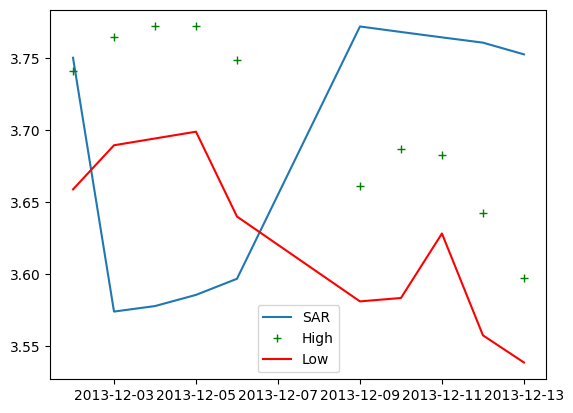

In [8]:
plt.plot(_10yearsdict['NVDA'].loc['2013-12-01':'2013-12-15'].index, _10yearsdict['NVDA'].loc['2013-12-01':'2013-12-15']['SAR'], label='SAR')
plt.plot(_10yearsdict['NVDA'].loc['2013-12-01':'2013-12-15'].index, _10yearsdict['NVDA'].loc['2013-12-01':'2013-12-15']['High'], 'g+', label='High')
plt.plot(_10yearsdict['NVDA'].loc['2013-12-01':'2013-12-15'].index, _10yearsdict['NVDA'].loc['2013-12-01':'2013-12-15']['Low'], 'r-', label='Low')
plt.legend()

In [9]:
####
# Determine the current position

for _ticker in _10yearsdict.keys():
    position = 1
    _10yearsdict[_ticker]['Signal'] = 'Hold'
    _10yearsdict[_ticker]['Position'] = -1
    for i in range(1, len(_10yearsdict[_ticker])):
        if _10yearsdict[_ticker]['SAR'].iloc[i] < _10yearsdict[_ticker]['Close'].iloc[i] and position == 1:
            _10yearsdict[_ticker]['Position'].iloc[i] = 1
            _10yearsdict[_ticker]['Signal'].iloc[i] = 'Buy'
            position = 0

        elif _10yearsdict[_ticker]['SAR'].iloc[i] > _10yearsdict[_ticker]['High'].iloc[i] and position == 0:
            _10yearsdict[_ticker]['Position'].iloc[i] = 0
            _10yearsdict[_ticker]['Signal'].iloc[i] = 'Sell'
            position = 1
        else:
            _10yearsdict[_ticker]['Position'].iloc[i] = -1
            _10yearsdict[_ticker]['Signal'].iloc[i] = 'Hold'



<ipython-input-9-3034230fa2dd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _10yearsdict[_ticker]['Position'].iloc[i] = -1
<ipython-input-9-3034230fa2dd>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _10yearsdict[_ticker]['Signal'].iloc[i] = 'Hold'
<ipython-input-9-3034230fa2dd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _10yearsdict[_ticker]['Position'].iloc[i] = 1
<ipython-input-9-3034230fa2dd>:11: SettingWithCopyWarn

In [10]:
! unzip /content/drive-download-20230728T135049Z-001.zip -d ./models

Archive:  /content/drive-download-20230728T135049Z-001.zip
  inflating: ./models/ADI.joblib     
  inflating: ./models/AAPL.h5        
  inflating: ./models/AVGO.joblib    
  inflating: ./models/BAC.h5         
  inflating: ./models/ACN.joblib     
  inflating: ./models/ADBE.joblib    
  inflating: ./models/AMAT.joblib    
  inflating: ./models/AAPL.joblib    
  inflating: ./models/AMD.joblib     
  inflating: ./models/BAC.joblib     
  inflating: ./models/ABBV.joblib    
  inflating: ./models/BA.joblib      
  inflating: ./models/ADP.joblib     
  inflating: ./models/AMZN.joblib    
  inflating: ./models/ABT.joblib     
  inflating: ./models/AXP.joblib     
  inflating: ./models/AMGN.joblib    
  inflating: ./models/AMT.joblib     
  inflating: ./models/CAT.joblib     
  inflating: ./models/AXP.h5         
  inflating: ./models/BA.h5          
  inflating: ./models/ADI.h5         
  inflating: ./models/AMAT.h5        
  inflating: ./models/CI.joblib      
  inflating: ./models/BMY.job

In [ ]:
# load models

models = {}
scalers = {}
for i, _ticker in enumerate(_10yearsdict.keys(), 1):
    print(f"{i}/{len(_10yearsdict.keys())}")
    models[_ticker] = load_model(f"/content/models/{_ticker}.h5")
    scalers[_ticker] = load(f"/content/models/{_ticker}.joblib")

1/99
2/99
3/99
4/99
5/99
6/99
7/99
8/99
9/99
10/99
11/99
12/99
13/99
14/99
15/99
16/99
17/99
18/99
19/99
20/99
21/99
22/99
23/99
24/99
25/99
26/99
27/99
28/99
29/99
30/99
31/99
32/99
33/99
34/99
35/99
36/99
37/99
38/99
39/99
40/99
41/99
42/99
43/99
44/99
45/99
46/99
47/99
48/99
49/99
50/99
51/99
52/99
53/99
54/99
55/99
56/99
57/99
58/99
59/99
60/99
61/99
62/99
63/99
64/99
65/99
66/99
67/99
68/99
69/99
70/99
71/99
72/99
73/99
74/99
75/99
76/99
77/99
78/99
79/99
80/99
81/99
82/99
83/99
84/99
85/99
86/99
87/99
88/99
89/99
90/99
91/99
92/99
93/99
94/99
95/99
96/99
97/99
98/99


OSError: ignored

In [11]:
# load models
from glob import glob

models = {}
scalers = {}
for h5, joblib in zip(glob('/content/models/*.h5'), glob('/content/models/*.joblib')):
    _ticker = h5.split('/')[-1][:-3]
    models[_ticker] = load_model(h5)
    scalers[_ticker] = load(joblib)

In [12]:
models.keys(), _10yearsdict.keys()

(dict_keys(['QCOM', 'JPM', 'BA', 'NFLX', 'AMAT', 'MMC', 'MRK', 'MA', 'CMCSA', 'ZTS', 'ISRG', 'ABT', 'ACN', 'LLY', 'SPGI', 'NVDA', 'WMT', 'UNP', 'PG', 'CB', 'V', 'AMT', 'ADI', 'LOW', 'BLK', 'GOOGL', 'TMO', 'MS', 'TMUS', 'HON', 'VZ', 'LRCX', 'PLD', 'KO', 'WFC', 'NEE', 'CI', 'MSFT', 'ADBE', 'DIS', 'TSLA', 'HD', 'LIN', 'AMD', 'MDLZ', 'CSCO', 'NOW', 'RTX', 'GOOG', 'INTU', 'MCD', 'AMGN', 'SYK', 'PEP', 'UPS', 'PM', 'SBUX', 'AVGO', 'MO', 'ORCL', 'GILD', 'IBM', 'MDT', 'GS', 'TJX', 'DE', 'ETN', 'T', 'LMT', 'CVS', 'XOM', 'INTC', 'AAPL', 'ADP', 'CVX', 'BRK-B', 'DHR', 'ELV', 'CAT', 'AXP', 'GE', 'REGN', 'UNH', 'BMY', 'C', 'BKNG', 'AMZN', 'HCA', 'NKE', 'TXN', 'SCHW', 'META', 'ABBV', 'COST', 'COP', 'VRTX', 'PFE', 'CRM', 'BAC', 'JNJ']),
 dict_keys(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'BRK-B', 'V', 'UNH', 'JPM', 'JNJ', 'XOM', 'LLY', 'WMT', 'MA', 'AVGO', 'PG', 'HD', 'ORCL', 'CVX', 'MRK', 'KO', 'ABBV', 'PEP', 'BAC', 'ADBE', 'COST', 'CRM', 'MCD', 'CSCO', 'TMO', 'ACN', 'NFLX', '

In [13]:
for tick in list(_10yearsdict.keys()):
    if tick not in models.keys():
        del _10yearsdict[tick]
print(len(_10yearsdict))

98


In [14]:
_10yearsdict

{'AAPL':                   Open        High         Low       Close     Volume  \
 2013-08-01   14.131460   14.164016   14.054251   14.160295  206250800   
 2013-08-02   14.201532   14.351606   14.159673   14.341993  274783600   
 2013-08-05   14.408664   14.594086   14.329906   14.556257  318855600   
 2013-08-06   14.511915   14.631912   14.330523   14.426025  334857600   
 2013-08-07   14.381065   14.480288   14.318120   14.417653  298858000   
 ...                ...         ...         ...         ...        ...   
 2023-07-25  193.330002  194.440002  192.919998  193.619995   37283200   
 2023-07-26  193.669998  195.639999  193.320007  194.500000   47471900   
 2023-07-27  196.020004  197.199997  192.550003  193.220001   47460200   
 2023-07-28  194.669998  196.630005  194.139999  195.830002   48254600   
 2023-07-31  196.059998  196.490005  195.259995  196.449997   38778100   
 
             Dividends  Stock Splits         SAR Signal  Position  
 2013-08-01        0.0           0

In [15]:
class Percentages:
    def __init__(self, ticker_names=None, ticker_percentages=None):
        self.ticker_names = ticker_names if type(ticker_names) == list else []
        self.ticker_percentages = ticker_percentages if type(ticker_percentages) == list else []
        self.being_used = [False]*len(ticker_percentages) if type(ticker_percentages) == list else []

    def is_empty(self):
        return len(self.ticker_names) == 0

    def get_weight(self, ticker_name, delete = True):
        # import pdb; pdb.set_trace()
        self.__clear__()
        try:
          i = self.ticker_names.index(ticker_name)
        except:
          return 0
        if delete:
            self.being_used[i] = False
        return self.ticker_percentages[i]

    def set_ticker(self, ticker_name):
        self.__clear__()
        if False in self.being_used and not ticker_name in self.ticker_names:
            i = self.being_used.index(False)
            self.being_used[i] = True
            self.ticker_names[i] = ticker_name
            return True
        return False

    def clear(self):
        self.ticker_names = []
        self.ticker_percentages = []
        self.being_used = []

    def ___redistribute_weights__(self, weights, epsilon = 0.01):
        self.__clear__()
        sum_weights = sum(weights)

        # If there are zero-valued elements
        if 0 in weights:
            # The number of zero-valued elements
            num_zeros = weights.count(0)

            # The total epsilon to be subtracted from non-zero elements
            total_epsilon = num_zeros * epsilon

            # New weights after adding epsilon to zero-valued elements and subtracting it from non-zero elements proportionally
            weights = [(w - (w/sum_weights)*total_epsilon if w > 0 else epsilon) for w in weights]

        return weights

    def update(self, ticker_names, ticker_percentages):
        self.ticker_names = ticker_names
        self.ticker_percentages = self.___redistribute_weights__(ticker_percentages)
        self.being_used = [True]*len(ticker_percentages)

    def is_in(self, key):
        return key in self.ticker_names

    def __clear__(self):
      for i, key in enumerate(self.ticker_names):
        if len(key) == 0:
          self.being_used[i] = False

    def __str__(self):
        return "\n".join([f"{ticker}-{weight}" for ticker, weight in zip(self.ticker_names, self.get_weight)])


class Ticker:
    def __init__(self, name, buy_date, sell_date, inversion_percentage, buy_price, sell_price, stocks_amount, cost, capital):

        self.buy_date = buy_date
        self.sell_date = sell_date
        self.name = name
        self.inversion_percentage = inversion_percentage
        self.buy_price = buy_price
        self.sell_price = sell_price
        self.stocks_amount = stocks_amount
        self.cost = cost
        self.capital = capital

    def __str__(self):
        return f"Ticker: {self.name}, buy: {self.buy_date}, sell: {self.sell_date}, investment: {self.inversion_percentage*100}%"

class Capital:
    def __init__(self):
        self.operations = {}
        self.dates = {}

    def __consolidate_operations__(self, operations):
        for key, value in operations.items():
            if key in self.operations.keys():
                if len(value) != 2:
                    continue
                self.operations[key].append(value[1])
            else:
                self.operations[key] = value[0]

    def __get_oldest_date__(self):
        sorted_dates = sorted([value[0] for key, value in self.operations.items() if len(value)==2], key=lambda x: datetime.strptime(x, ""))

    def set_today_operations(self, operations):
        self.__consolidate_operations__(operations)
        oldest_date = self.__get_oldest_date__()
        available_tickers = dict(filter(lambda item, value: len(value)==2, self.operations.items()))


class Operations:
    def __init__(self, data, i, capital, comission, models, scalers):
        self.data = data
        self.historical_operations = []
        self.operations = {}
        self.amount_of_tickers = 0
        self.ticker_weights = Percentages()
        self.tickers = []
        self.candidate_tickers = []
        self.is_weight_calc_needed = False
        self.tickers_to_sell = []
        self.capital = capital
        self.capital_track = {}
        self.comission = comission
        self.models = models
        self.scalers = scalers
        self.predictions = {}
        self.tickers_bought = []
        self.sequence_log = []
        self.currently_bought_tickers = {}
        self.date_capital = {}
        self.aux_capital = capital
        self.cum_operations = defaultdict(int)
        # TODO: for debugging porpuses only
        self.control = 0
        with open('purchase_log.txt','w') as log:
            log.write('')

    def __pd_fill_diagonal__(self, df_matrix, value=0):
        mat = df_matrix.values
        n = mat.shape[0]
        mat[range(n), range(n)] = value
        return pd.DataFrame(mat, columns=df_matrix.columns)

    def __get_operation_date__(self, date,tick):
        """
        Get the next day in a operation
        """
        try:
            # value = self.data[list(self.data.keys())[0]].iloc[self.data[list(self.data.keys())[0]].index.get_loc(date)+1].name
            value = self.data[tick].iloc[self.data[tick].index.get_loc(date)+1].name
        except:
            value = "tomorrow"
        return value

    def __flush__(self):
        """
        write all the buy/sell operations
        """
        aux_operations = self.operations.copy()
        cum_capital = 0
        less_capital = 0
        for key, value in aux_operations.items():
            if len(value) == 1:
                continue
            if self.capital <= 0:
                return False

            if value[0] == 'tomorrow':
                del self.operations[key]
                continue

            if not key == self.sequence_log[0]:
              continue
            else:
              self.sequence_log.remove(key)

            # Increase the capital for each sold ticker
            for t_b in self.tickers_bought.copy():
                tickers_list = list(self.currently_bought_tickers.keys())
                if t_b in tickers_list:
                    # ticker_index = len(tickers_list) - tickers_list[::-1].index(t_b) -1
                    required_ticker = self.currently_bought_tickers[t_b]
                    if value[0] >= required_ticker.sell_date:
                        sell_price = required_ticker.sell_price * required_ticker.stocks_amount - required_ticker.stocks_amount * self.comission
                        # self.capital += sell_price - sell_price*self.comission
                        self.capital += sell_price
                        with open('purchase_log.txt','at') as log:
                          log.write(f'selling {t_b} on {required_ticker.sell_date} at {sell_price}\t capital before transaction = {self.capital-sell_price} capital_left = {self.capital}\n')
                        self.tickers_bought.remove(t_b)
                        del self.currently_bought_tickers[t_b]


            if value[0] not in self.date_capital:
                self.date_capital[value[0]] = self.capital

            capital = self.date_capital[value[0]]

            weight = self.ticker_weights.get_weight(key)
            stocks = np.floor(((capital * weight) - (capital * weight / self.data[key].loc[value[0], 'Open'] * self.comission)) / self.data[key].loc[value[0], 'Open'])
            if stocks == 0:
                continue
            # Calculate the cost based on the initial capital and the number of stocks bought
            cost = stocks * self.data[key].loc[value[0], 'Open']

            ticker = Ticker(
                key,
                value[0],
                value[1],
                weight,
                self.data[key].loc[value[0], 'Open'] if value[0] != 'tomorrow' else "tomorrow",
                self.data[key].loc[value[1], 'Open'] if value[1] != 'tomorrow' else "tomorrow",
                stocks,
                cost,
                capital
                 # Set the current capital for this ticker
            )
            self.currently_bought_tickers[key] = ticker
            self.tickers.append((key,ticker))
            print(f"Total no of operations {key}=",len(self.tickers),'Capital:',capital)
            del self.operations[key]
            if key in self.tickers_bought:
                self.capital -= cost  # Reduce capital for the buy operation
                with open('purchase_log.txt','at') as log:
                    log.write(f'purchasing {key} on {value[0]} at {cost}\t capital before transaction = {self.capital+cost} capital_left = {self.capital}\n')
            less_capital += cost

        self.aux_capital -= less_capital
        self.aux_capital += cum_capital



        return True



    def __get_tickers_to_buy__(self, candidates_dataframe_corr):
        candidates_dataframe_corr = candidates_dataframe_corr.loc[:, candidates_dataframe_corr.columns != '^GSPC']
        threshold = 0.65
        internal_control = 0
        while True:
            if internal_control == 100:
                return columns_to_buy
            columns_to_buy = candidates_dataframe_corr.columns[candidates_dataframe_corr.mean().ge(threshold)]
            if len(columns_to_buy) >= 4:
                return columns_to_buy
            threshold *= 0.99
            internal_control += 1

    def __calculate_weights__(self, index):
        benchmark = yf.download('^GSPC', start=self.data[list(self.data.keys())[0]].index[0], end=self.data[list(self.data.keys())[0]].index[-1])
        benchmark = benchmark.iloc[:index, 3:4].rename(columns={'Close': '^GSPC'})
        candidates_dataframe = [
            self.data[_ticker].iloc[:index, 3:4].rename(columns={'Close': _ticker}) for _ticker in self.candidate_tickers
        ]
        candidates_dataframe.append(benchmark)
        candidates_dataframe = pd.concat(candidates_dataframe, axis=1)
        candidates_dataframe = np.log(candidates_dataframe).diff()
        candidates_dataframe = candidates_dataframe.dropna()
        candidates_dataframe_corr = candidates_dataframe.corr()
        candidates_dataframe_corr = self.__pd_fill_diagonal__(candidates_dataframe_corr)
        columns_to_buy = self.__get_tickers_to_buy__(candidates_dataframe_corr)
        candidates_dataframe_cov = candidates_dataframe[columns_to_buy].cov()*252
        returns = expected_returns.capm_return(
            candidates_dataframe.loc[:, columns_to_buy],
            market_prices = candidates_dataframe.loc[:, candidates_dataframe.columns == '^GSPC'],
            returns_data= True,
            risk_free_rate=0.07/100,
            frequency=252
            )
        ef = EfficientFrontier(returns, candidates_dataframe_cov,weight_bounds=(0,1))
        weights = ef.max_sharpe()
        self.ticker_weights.update(list(ef.clean_weights().keys()), list(ef.clean_weights().values()))

    def __get_most_value_candidate__(self, index):
        values = {}
        most_valuable_ticker = ""
        max_value = -math.inf
        available_candidates = set(self.candidate_tickers).difference(self.operations.keys())
        available_candidates = list(available_candidates)

        for _ticker in available_candidates:
            scaled = self.scalers[_ticker].transform(self.data[_ticker].iloc[index-60:index, 1].values.reshape(-1, 1))
            predicted = self.models[_ticker](scaled.reshape(1,-1))
            predicted = self.scalers[_ticker].inverse_transform(predicted.numpy().reshape(-1,1)).squeeze()
            actual = self.data[_ticker].iloc[index, 1]

            value = (predicted-actual)/actual
            if value > max_value:
                most_valuable_ticker = _ticker
                max_value = value
        self.control += 1
        return most_valuable_ticker

    def __get_cost__(self, key, date):
        weight = self.ticker_weights.get_weight(key, False)
        # import pdb; pdb.set_trace()
        if date in self.date_capital:
          capital = self.date_capital[date]
        else:
          capital = self.capital
        stocks = np.floor(((capital*weight)-(capital*weight/self.data[key].loc[date, 'Open']*self.comission))/self.data[key].loc[date, 'Open'])
        cost = self.data[key].loc[date, 'Open'] * stocks
        return cost

    def __get_sell__(self,key, date):
        total_sell_price = (self.ticker_weights.get_weight(key, False) * self.data[key].loc[date, 'Open'])
        # return total_sell_price - total_sell_price*self.comission
        return total_sell_price - self.comission


    def finish_day(self, index):
        """
        run when all the tickers were processed for a day.
        """
        # import pdb; pdb.set_trace()
        if self.ticker_weights.is_empty() and len(self.candidate_tickers) > 0:
            self.__calculate_weights__(index)
        date = str(self.data[list(self.data.keys())[0]].iloc[index].name)
        for key, being_used in zip(self.ticker_weights.ticker_names, self.ticker_weights.being_used):
            # Add ticker if it is not already added and this ticker was saved (being_used = True)
            if being_used and not key in self.operations.keys():
                if len(key) > 0:
                    self.operations[key] = [self.__get_operation_date__(date, key)]
                    self.capital_track[key] = self.capital
                    self.tickers_bought.append(key)
                    self.sequence_log.append(key)
                    # self.capital -= self.__get_cost__(key, self.__get_operation_date__(date, key))
                    print(f"Operations {key}.\n",self.capital_track[key])

            elif not being_used and len(self.candidate_tickers) > 0: # if we have space for one more ticker
                # import pdb; pdb.set_trace()
                while True:
                    ticker = self.__get_most_value_candidate__(index)
                    is_added_key = self.ticker_weights.set_ticker(ticker)
                    if is_added_key or not ticker:
                        break
                    else:
                        # import pdb;pdb.set_trace()
                        if ticker in self.candidate_tickers:
                            self.candidate_tickers.pop(self.candidate_tickers.index(ticker))
                        # else:
                            # import pdb; pdb.set_trace()
                if ticker:
                    self.ticker_weights.set_ticker(ticker)
                    # TODO: test this line below
                    self.operations[ticker] = [self.__get_operation_date__(date, ticker)]
                    # self.capital -= self.__get_cost__(key, self.__get_operation_date__(date, key))
                    self.tickers_bought.append(ticker)
                    self.sequence_log.append(ticker)
                    self.capital_track[ticker] = self.capital
                print(ticker)
                # print(f"Operations {ticker}.\n",self.capital_track[ticker])
        is_capital_available = self.__flush__()
        self.candidate_tickers = []
        return is_capital_available

    def sell_all(self, date):
        # map(
        #     partial(
        #             lambda _ticker: self.operations[_ticker].append(self.__get_operation_date__(date)) if len(self.operations[_ticker]) == 1 else None,
        #             date
        #         ),
        #         self.operations.keys()
        #     )

        for key in self.operations.keys():
            if len(self.operations[key]) == 1:
                #import pdb; pdb.set_trace()
                self.operations[key].append(self.__get_operation_date__(date, key))
                self.capital += self.__get_sell__(key, self.__get_operation_date__(date, key))

        is_capital_available = self.__flush__()
        self.predictions.clear()
        self.ticker_weights.clear()
        self.candidate_tickers = []

        return is_capital_available

    def __search_ticker__(self, ticker):
        if not self.ticker_weights:
            ... # calculate sharpe and get weights

        for _ticker in reversed(self.operations):
            if list(_ticker.keys())[0] == ticker:
                self.amount_of_tickers -= 1
                return _ticker
        self.amount_of_tickers += 1
        return dict(_ticker=[])

    def add_ticker(self, ticker, is_buy_operation, date):
        """
        Add a ticker for buy or sell
        """
        if is_buy_operation:
            # import pdb; pdb.set_trace()
            if not ticker in self.candidate_tickers:
                self.candidate_tickers.append(ticker)
        else:
            # if ticker is in operations it means it has been bought so we need to sell it
            if ticker in self.operations.keys():
                # import pdb; pdb.set_trace()
                self.operations[ticker].append(self.__get_operation_date__(date, ticker))
            # self.tickers_to_sell[ticker] = self.__get_operation_date__(date)

dataframelength = len(list(_10yearsdict.values())[0])


# get the index value from 6 months in the future
initial_state = len(list(_10yearsdict.values())[0].loc[:list(_10yearsdict.values())[0].index[0] + pd.Timedelta(weeks=6*4)])
capital = 95000
comission = 0.0035

operations = Operations(_10yearsdict, i, capital, comission, models, scalers)
# last_month = list(_10yearsdict.values())[0].index[0].month
initial_date = list(_10yearsdict.values())[0].index[i]
date_control = initial_date
for i in range(initial_state, dataframelength):
    for _ticker in _10yearsdict.keys():
        # Buy position
        if _10yearsdict[_ticker]['SAR'].iloc[i] < _10yearsdict[_ticker]['Low'].iloc[i]:
            operations.add_ticker(_ticker, True, _10yearsdict[_ticker].iloc[i].name)
        # Sell position
        elif _10yearsdict[_ticker]['SAR'].iloc[i] > _10yearsdict[_ticker]['High'].iloc[i]:
            operations.add_ticker(_ticker, False, _10yearsdict[_ticker].iloc[i].name)
    is_capital_available = operations.finish_day(i)
    if not is_capital_available:
        is_capital_available = operations.sell_all(_10yearsdict[_ticker].index[0])
        if not is_capital_available:
            break
    if (_10yearsdict[_ticker].index[i].year - date_control.year) *12 + (_10yearsdict[_ticker].index[i].month - date_control.month) >= 3:
        # last_month = _10yearsdict[_ticker].index[0].month
        # import pdb;pdb.set_trace()
        date_control = _10yearsdict[_ticker].index[i]
        is_capital_available = operations.sell_all(_10yearsdict[_ticker].index[i])
        if not is_capital_available:
            break

[*********************100%***********************]  1 of 1 completed
Operations WFC.
 95000
Operations AXP.
 95000
Operations BLK.
 95000
Operations MMC.
 95000
Total no of operations WFC= 1 Capital: 95000
Total no of operations AXP= 2 Capital: 95000
Total no of operations BLK= 3 Capital: 95000
Total no of operations MMC= 4 Capital: 95000
T
TSLA
NEE
GILD
Total no of operations T= 5 Capital: 90925.24392576463
GE
Total no of operations TSLA= 6 Capital: 90925.24392576463
BAC
Total no of operations NEE= 7 Capital: 90925.24392576463
Total no of operations GILD= 8 Capital: 90925.24392576463
Total no of operations GE= 9 Capital: 21900.260819549694
Total no of operations BAC= 10 Capital: 70691.98170771879
AMD
NVDA
WFC
T
Total no of operations AMD= 11 Capital: 91895.03747906478
Total no of operations NVDA= 12 Capital: 91895.03747906478
Total no of operations WFC= 13 Capital: 91895.03747906478
Total no of operations T= 14 Capital: 91895.03747906478
BAC
INTC
MO
COP
Total no of operations BAC= 15 

In [16]:
operations.currently_bought_tickers, operations.tickers_bought

({'WFC': <__main__.Ticker at 0x7fda3976ebc0>},
 ['WFC', 'GE', 'BAC', 'IBM', 'T'])

In [17]:
data_dict = {
    'ticker': [],
    'buy date': [],
    'sell date': [],
    'investment': [],
    'buy': [],
    'sell': [],
    'stocks': [],
    'cost':[],
    'capital': []

}
for key, ticker_data in operations.tickers:
    data_dict['ticker'].append(ticker_data.name)
    data_dict['buy date'].append(ticker_data.buy_date)
    data_dict['sell date'].append(ticker_data.sell_date)
    data_dict['investment'].append(ticker_data.inversion_percentage)
    data_dict['buy'].append(ticker_data.buy_price)
    data_dict['sell'].append(ticker_data.sell_price)
    data_dict['stocks'].append(ticker_data.stocks_amount)
    data_dict['cost'].append(ticker_data.cost)
    data_dict['capital'].append(ticker_data.capital)

In [18]:
consolidated = pd.DataFrame(data_dict)
consolidated['comission'] = pd.Series(comission, index=consolidated.index)
# consolidated['capital'] = pd.Series(capital, index=consolidated.index)
consolidated['income'] = (consolidated['stocks']*consolidated['sell'])-(consolidated['comission']*consolidated['stocks'])
consolidated['balance'] = consolidated['income']-consolidated['cost']
consolidated['benefit'] = consolidated['balance'].cumsum()
consolidated

ticker   buy date  sell date  investment         buy        sell  stocks  \
0      WFC 2014-01-21 2014-01-28     0.23235   35.427210   34.878777   622.0   
1      AXP 2014-01-21 2014-01-28     0.25504   80.033432   74.707734   302.0   
2      BLK 2014-01-21 2014-01-27     0.23126  250.773216  241.184431    87.0   
3      MMC 2014-01-21 2014-01-27     0.28134   40.708059   38.748896   656.0   
4        T 2014-01-29 2014-01-30     0.23235   11.973378   12.394665  1763.0   
..     ...        ...        ...         ...         ...         ...     ...   
721      T 2023-06-20 2023-07-11     0.23235   15.739373   15.290000  2291.0   
722      C 2023-06-20 2023-06-22     0.25504   47.910000   47.220001   826.0   
723     VZ 2023-06-20 2023-06-26     0.23126   35.445470   35.032855  1012.0   
724   GILD 2023-06-20 2023-06-27     0.28134   78.639999   76.650002   555.0   
725    WFC 2023-07-12 2023-07-28     0.23235   43.310001   46.049999   815.0   

             cost        capital  comission        income      balance  \
0    22035.724402   95000.000000     0.0035  21692.422210  -343.302192   
1    24170.096494   95000.000000     0.0035  22560.678679 -1609.417815   
2    21817.269797   95000.000000     0.0035  20982.740997  -834.528800   
3    26704.487027   95000.000000     0.0035  25416.979761 -1287.507267   
4    21109.065856   90925.243926     0.0035  21845.623947   736.558092   
..            ...            ...        ...           ...          ...   
721  36058.903157  155247.191935     0.0035  35021.371413 -1037.531745   
722  39573.659874  155247.191935     0.0035  39000.830008  -572.829866   
723  35870.815391  155247.191935     0.0035  35449.706819  -421.108573   
724  43645.199661  155247.191935     0.0035  42538.808347 -1106.391314   
725  35297.651119  152109.330437     0.0035  37527.896878  2230.245759   

          benefit  
0     -343.302192  
1    -1952.720008  
2    -2787.248807  
3    -4074.756074  
4    -3338.197983  
..            ...  
721  59209.660190  
722  58636.830324  
723  58215.721751  
724  57109.330437  
725  59339.576196  

[726 rows x 13 columns]

In [19]:
# sar < low: buy; sar>high: sell
#_10yearsdict['NVDA'].loc['2013-12-03':'2013-12-10']

In [20]:
consolidated.to_csv('/content/output.csv')

6